In [1]:
import pandas as pd
import numpy as np

clients = pd.read_csv('../data/processed/clients.csv')
orders = pd.read_csv('../data/processed/orders.csv')
orders_raw = pd.read_csv('../data/processed/orders_raw.csv')


In [4]:
# Check balance: include both count and percentage columns
balance_counts = clients['class'].value_counts().rename_axis('class').reset_index(name='count')
balance_percent = clients['class'].value_counts(normalize=True).rename_axis('class').reset_index(name='percentage')
balance = pd.merge(balance_counts, balance_percent, on='class')
(balance)

,class,count,percentage
0,HighTicket_Inefficient,12028,0.286722
1,HighTicket_Efficient,11385,0.271395
2,LowTicket_Efficient,10103,0.240834
3,LowTicket_Inefficient,8434,0.201049


In [5]:
clients

,client_id,city,channel,promotor_id,frequency,efficiency,total_orders,total_volume,total_income,total_cost,...,efficiency_max,efficiency_std,class,zero_visit_flag,avg_orders_per_month,avg_visits_per_month,visit_order_gap,inefficiency_cost,profit_per_visit,opportunity_cost
0,100006690,Madrid,AR,275609911,2.0,1.00,22,1658.706,1494.53,880,...,1.5,0.417424,LowTicket_Inefficient,False,1.833333,0.166667,-1.666667,-25.00,307.265,-512.108333
1,100008050,Barcelona,AR,368568690,1.0,20.00,14,3982.000,1905.59,140,...,20.0,0.000000,HighTicket_Efficient,True,1.166667,0.000000,-1.166667,-17.50,0.000,-0.000000
2,100042162,Barcelona,HR,455263770,1.0,0.25,14,1812.850,2243.30,980,...,0.5,0.116775,HighTicket_Inefficient,False,1.166667,0.333333,-0.833333,-12.50,315.825,-263.187500
3,100046227,Barcelona,AR,454554895,4.0,2.00,16,4590.180,2273.12,640,...,2.0,0.000000,HighTicket_Efficient,False,1.333333,0.166667,-1.166667,-17.50,816.560,-952.653333
4,100125158,Cadiz,HR,483340469,3.0,3.00,25,1266.500,2204.24,625,...,4.0,0.971825,HighTicket_Efficient,False,2.083333,0.083333,-2.000000,-30.00,1579.240,-3158.480000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41945,999934164,Barcelona,HR,480416490,2.0,2.00,23,691.000,785.30,575,...,4.0,1.236033,LowTicket_Efficient,False,1.916667,0.083333,-1.833333,-27.50,210.300,-385.550000
41946,999940211,Barcelona,AR,908993212,1.0,20.00,3,557.820,260.55,30,...,20.0,0.000000,LowTicket_Efficient,True,0.250000,0.000000,-0.250000,-3.75,0.000,-0.000000
41947,999940578,Madrid,AR,275609911,1.0,0.50,13,1101.524,1044.61,520,...,1.0,0.202260,LowTicket_Inefficient,False,1.083333,0.166667,-0.916667,-13.75,262.305,-240.446250
41948,999941988,Madrid,AR,677360818,3.0,1.50,36,5415.150,3828.31,1410,...,2.0,0.369274,HighTicket_Efficient,False,3.000000,0.166667,-2.833333,-42.50,1209.155,-3425.939167


In [156]:
# clients.to_csv("data/processed/clients.csv", index=False)

In [6]:
clients['visits_per_month'] = clients['total_promotor_visits'] / 12  # adjust period if needed

KeyError: 'total_promotor_visits'

In [ ]:
clients['visi'] = clients['visit_order_gap'] * 15

In [158]:
efficient_clients = clients[(clients['median_efficiency_orders'] > 1) & (clients['median_ticket_(eur)_year'] > 80)]

In [159]:
features = [
    'total_volume', 'total_income', 'total_profit',
    'median_ticket_(eur)_year', 'median_efficiency_orders',
    'median_efficiency_profit', 'total_promotor_calls', 'client_frequency'
]

In [160]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

X = efficient_clients[features]
y = efficient_clients['visits_per_month']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor()
model.fit(X_train, y_train)

clients['predicted_visits_per_month'] = model.predict(clients[features])
clients['visit_gap'] = (clients['total_promotor_visits'] / 12) - clients['predicted_visits_per_month']

In [161]:
clients

,client_id,channel,city,promotor_id,client_frequency,total_orders,total_volume,total_income,median_ticket_(eur)_year,median_ticket_(eur)_min,median_ticket_(eur)_max,median_ticket_(eur)_std,total_promotor_visits,total_promotor_calls,total_profit,median_efficiency_orders,median_efficiency_profit,quadrant,visits_per_month,predicted_visits_per_month,visit_gap
0,100006690,AR,Madrid,275609911,2.0,22,1658.706,1494.53,60.990,33.00,123.89,22.262210,44,0,614.53,0.50,10.4950,LowValue_Inefficient,3.666667,0.474055,3.192612
1,100008050,AR,Barcelona,368568690,1.0,14,3982.000,1905.59,132.370,66.96,187.10,38.756311,0,28,1765.59,1.00,1.0000,HighValue_Inefficient,0.000000,0.518176,-0.518176
2,100042162,HR,Barcelona,455263770,2.0,18,1812.850,2243.30,128.125,29.62,220.82,49.543046,56,0,1263.30,0.25,20.9450,HighValue_Inefficient,4.666667,0.438632,4.228035
3,100046227,AR,Barcelona,454554895,4.0,16,4590.180,2273.12,132.640,83.21,276.33,48.602430,32,32,1633.12,0.50,46.3200,HighValue_Inefficient,2.666667,0.516094,2.150572
4,100125158,HR,Cadiz,483340469,3.0,26,1266.500,2204.24,67.255,0.00,173.95,49.789599,25,0,1579.24,1.00,45.2550,LowValue_Inefficient,2.083333,0.472607,1.610727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42144,999934164,HR,Barcelona,480416490,2.0,23,691.000,785.30,38.330,25.55,55.23,9.544566,23,69,210.30,1.00,13.3300,LowValue_Inefficient,1.916667,0.485495,1.431172
42145,999940211,AR,Barcelona,908993212,1.0,3,557.820,260.55,76.430,75.02,109.10,19.281958,0,0,230.55,1.00,1.0000,LowValue_Inefficient,0.000000,0.242631,-0.242631
42146,999940578,AR,Madrid,275609911,1.0,13,1101.524,1044.61,64.315,0.00,183.56,41.173085,26,0,524.61,0.50,12.1575,LowValue_Inefficient,2.166667,0.477122,1.689544
42147,999941988,AR,Madrid,677360818,3.0,36,5415.150,3828.31,102.840,0.00,188.96,41.406391,70,70,2418.31,0.50,31.4200,HighValue_Inefficient,5.833333,0.673439,5.159894


In [162]:
#average visit_gap

average_gap = clients['visit_gap'].mean()

average_gap

3.5986486657203254

In [163]:
clients['quadrant'].unique()

array(['LowValue_Inefficient', 'HighValue_Inefficient',
       'LowValue_Efficient', 'HighValue_Efficient'], dtype=object)

In [164]:
clients_optimize = clients[
    (clients['quadrant'] == 'LowValue_Efficient') |
    (clients['quadrant'] == 'LowValue_Inefficient')
]

clients_optimize

,client_id,channel,city,promotor_id,client_frequency,total_orders,total_volume,total_income,median_ticket_(eur)_year,median_ticket_(eur)_min,median_ticket_(eur)_max,median_ticket_(eur)_std,total_promotor_visits,total_promotor_calls,total_profit,median_efficiency_orders,median_efficiency_profit,quadrant,visits_per_month,predicted_visits_per_month,visit_gap
0,100006690,AR,Madrid,275609911,2.0,22,1658.706,1494.53,60.990,33.00,123.89,22.262210,44,0,614.53,0.50,10.4950,LowValue_Inefficient,3.666667,0.474055,3.192612
4,100125158,HR,Cadiz,483340469,3.0,26,1266.500,2204.24,67.255,0.00,173.95,49.789599,25,0,1579.24,1.00,45.2550,LowValue_Inefficient,2.083333,0.472607,1.610727
5,100137028,AR,Murcia,733727842,2.0,24,3930.000,1463.61,61.070,52.72,70.31,6.678725,0,46,1233.61,1.00,1.0000,LowValue_Inefficient,0.000000,0.553444,-0.553444
8,100175807,HR,Murcia,205150913,8.0,82,3694.530,4658.89,46.500,23.25,168.26,29.241659,0,0,3858.89,1.00,1.0000,LowValue_Inefficient,0.000000,0.512506,-0.512506
11,100198216,AR,Madrid,358006057,1.5,9,785.496,571.66,63.310,52.22,82.95,8.739103,9,9,346.66,1.00,38.3100,LowValue_Inefficient,0.750000,0.486799,0.263201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42138,999873719,AR,Granada,388409380,1.0,14,889.450,991.53,60.425,50.36,183.10,34.609591,28,0,431.53,0.50,10.2125,LowValue_Inefficient,2.333333,0.422272,1.911061
42140,999883552,AR,Barcelona,496352806,3.5,15,2426.390,1162.99,67.730,54.70,156.61,27.415118,60,0,112.99,0.25,-0.5675,LowValue_Inefficient,5.000000,0.474750,4.525250
42144,999934164,HR,Barcelona,480416490,2.0,23,691.000,785.30,38.330,25.55,55.23,9.544566,23,69,210.30,1.00,13.3300,LowValue_Inefficient,1.916667,0.485495,1.431172
42145,999940211,AR,Barcelona,908993212,1.0,3,557.820,260.55,76.430,75.02,109.10,19.281958,0,0,230.55,1.00,1.0000,LowValue_Inefficient,0.000000,0.242631,-0.242631


In [165]:
non_efficient = clients[clients['median_efficiency_orders'] < 1]
efficient_clients = clients[clients['median_efficiency_orders'] >= 1]

efficient_gap = efficient_clients['visit_gap'].mean()
inefficient_gap = non_efficient['visit_gap'].mean()

print(f"Efficient clients average absolute visit gap: {efficient_gap:.2f}")
print(f"Inefficient clients average absolute visit gap: {inefficient_gap:.2f}")

Efficient clients average absolute visit gap: 0.02
Inefficient clients average absolute visit gap: 7.20


/var/folders/lv/gn03ly3n62g1g9qqycdm72800000gn/T/ipykernel_33465/2356558328.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


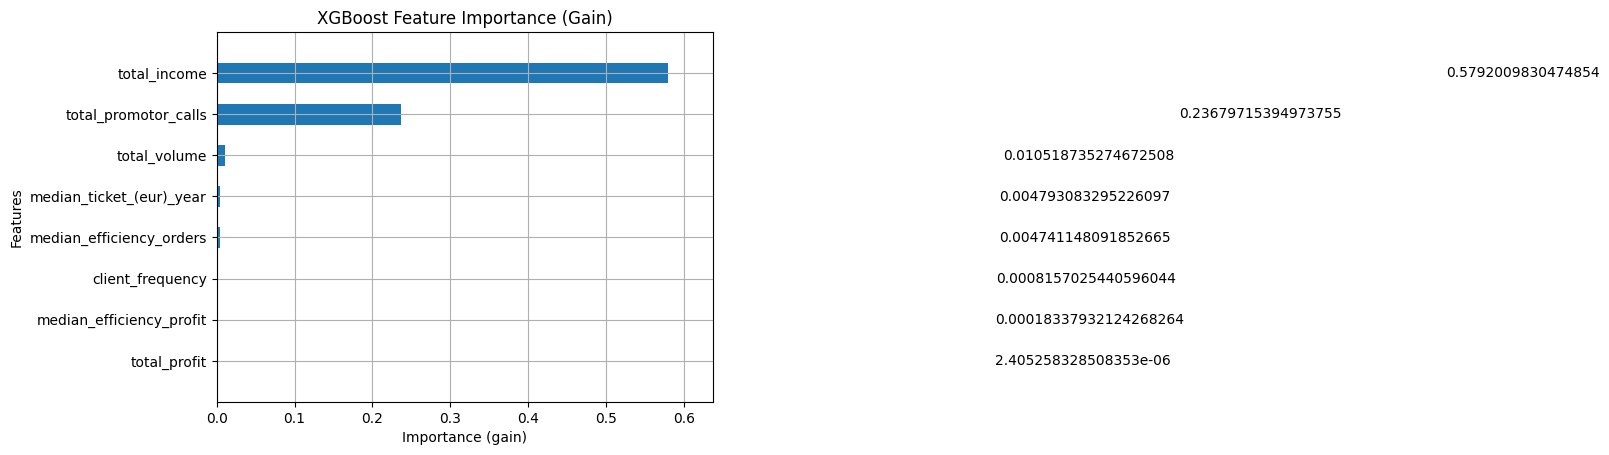

In [166]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model, importance_type='gain', xlabel='Importance (gain)', height=0.5)
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()